## Computational Geometry Samples in Python

Reference: [Discrete and Computational Geometry (2011) Devadoss and O'Rourke](https://press.princeton.edu/titles/9489.html)

In [1]:
%load_ext autoreload
%autoreload 2

import itertools
import circumcircle
import triangle
import numpy as np
import scipy
import scipy.spatial
import scipy.optimize
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
%matplotlib inline
import math
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import pickle
import shapefile # From the Python 'pyshp' library.
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.collections import PolyCollection
from matplotlib.collections import PatchCollection
from matplotlib import colors
import time

## 1) Introduction: What is Computational Geometry? Why is it important?

**Definition**: the study of computer algorithms that perform geometric operations. 
    
**Applications**:
 - computer graphics
 - computer-aided design / drafting (CAD)
 - robotic motion planning / collision avoidance
 - geographic information systems (GIS) / search and rescue, etc.
 - computer vision (3D reconstruction)
 - computational biochemistry / virology
 - epidemiology (water source contamination)
 - ecology (species habitat estimates based on sightings)
 - integrated circuit design
 - enconomical construction of physical networks
 - cooking ingredient logistics (success polygons)
 
 A "young field," with modern computational geometry starting in ~ the 1970s.

## 2) Polygons

### 2.1 Definition: 
"A polygon is the closed region of the plane bounded by a finite collection of line segments forming a closed curve that does not intersect itself."

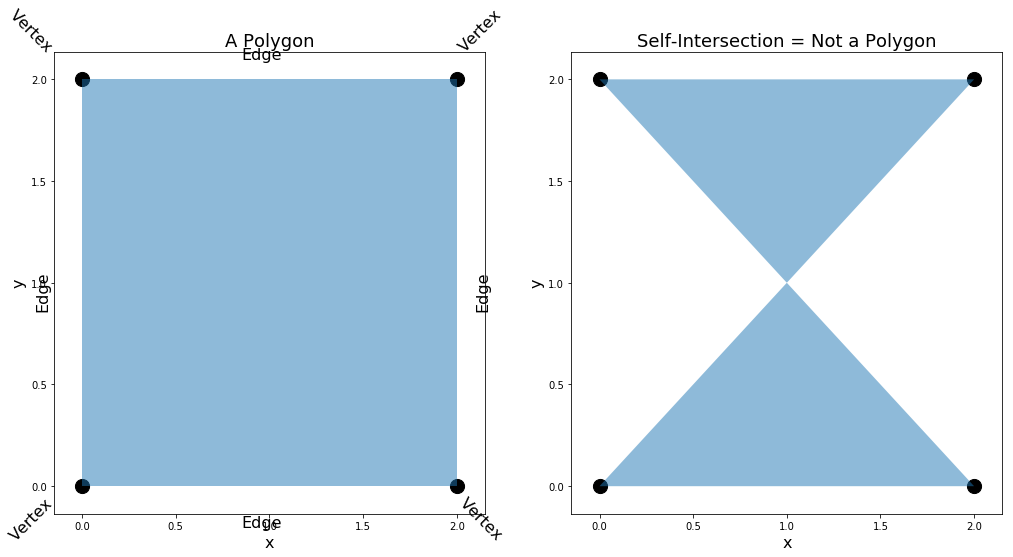

In [2]:
#plot an example of a polygon and an object that fails to be a polygon


fig_2_1 = matplotlib.pyplot.figure()

polygon_vertices = np.array([[0,2], #top left
                             [2,2], #top right
                             [2,0], #bottom right
                             [0,0]]) #bottom left

self_intersection_vertices = np.array([[0,2], #top left
                                       [2,2], #top right
                                       [0,0], #bottom left
                                       [2,0]]) #bottom right

ax = fig_2_1.add_subplot(121)
ax.scatter(polygon_vertices[...,0], polygon_vertices[...,1], color='black', s=200, label = 'vertices')
polygon = Polygon(polygon_vertices, alpha = 0.5)
ax.add_patch(polygon)
ax.set_title('A Polygon', fontsize=18)

ax2 = fig_2_1.add_subplot(122)
ax2.scatter(self_intersection_vertices[...,0], self_intersection_vertices[...,1], color='black', s=200, label = 'vertices')
polygon = Polygon(self_intersection_vertices, alpha = 0.5)
ax2.add_patch(polygon)
ax2.set_title('Self-Intersection = Not a Polygon', fontsize=18)

for axis in [ax,ax2]:
    axis.set_xlabel('x', fontsize = 16)
    axis.set_ylabel('y', fontsize = 16)

#some text labels for the polygon case
ax.text(0.85,2.1,'Edge', fontsize = 16)
ax.text(0.85,-0.2,'Edge', fontsize = 16)
ax.text(-0.25,1.0,'Edge', fontsize = 16, rotation=90)
ax.text(2.1,1.0,'Edge', fontsize = 16, rotation=90)
ax.text(-0.4,2.3,'Vertex', fontsize = 16, rotation=-45)
ax.text(2.0,2.3,'Vertex', fontsize = 16, rotation=45)
ax.text(-0.4,-0.1,'Vertex', fontsize = 16, rotation=45)
ax.text(2.0,-0.1,'Vertex', fontsize = 16, rotation=-45)

fig_2_1.set_size_inches(17,8.5)

### 2.2 Every Polygon Has A Triangulation:

Some useful definitions:
    
1. **Diagonal**: a line segment connecting two vertices of P and lying in the interior of P, not touching $\partial$P except at its endpoints
2. **Triangulation**: a decomposition of P into triangles by a maximal set of noncrossing diagonals

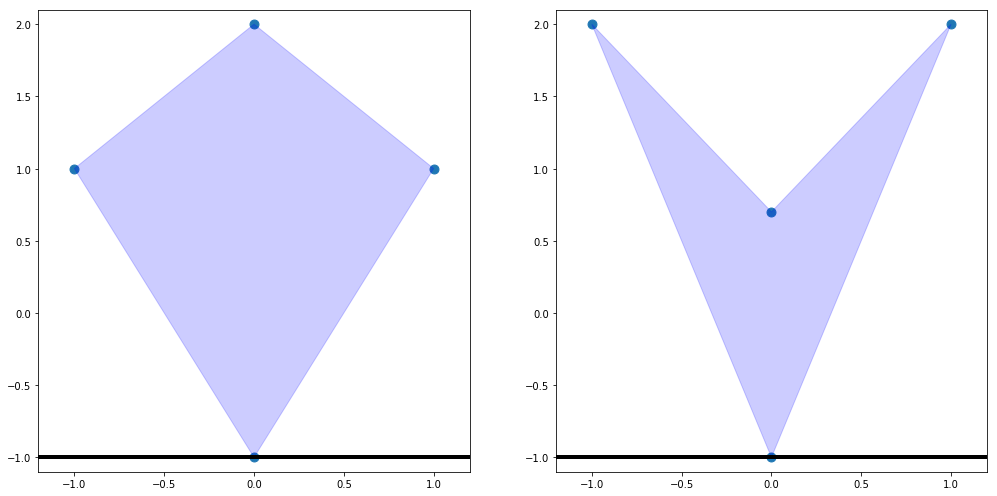

In [3]:
@interact(y_value_p1 = widgets.FloatSlider(min=-1,max=2.1,step=0.1,value=-1),
          y_value_p2 = widgets.FloatSlider(min=-1,max=2.1,step=0.1,value=-1),
          new_diagonal_p2 = False)
def polygon_sweep(y_value_p1, y_value_p2, new_diagonal_p2):
    fig_2_2 = matplotlib.pyplot.figure()
    fig_2_2.set_size_inches(17,8.5)

    polygon_1 = np.array([[0,2],#top
                          [-1,1],#left
                          [0,-1], #bottom
                          [1,1]])#right

    polygon_2 = np.array([[0,0.7],#top
                          [-1,2],#left
                          [0,-1],#bottom
                          [1,2]])#right

    ax1 = fig_2_2.add_subplot(121)
    p1 = Polygon(polygon_1, color='blue', alpha = 0.2)
    ax1.add_patch(p1)
    ax1.scatter(polygon_1[...,0], polygon_1[...,1], s=80)
    ax2 = fig_2_2.add_subplot(122)
    p2 = Polygon(polygon_2, color='blue', alpha = 0.2)
    ax2.add_patch(p2)
    ax2.scatter(polygon_2[...,0], polygon_2[...,1], s=80)

    for axis in [ax1,ax2]:
        axis.set_xlim(-1.2,1.2)
        axis.set_ylim(-1.1,2.1)
    ax1.axhline(y=y_value_p1, lw=4, color = 'black')
    ax2.axhline(y=y_value_p2, lw=4, color = 'black')
    if new_diagonal_p2:
        ax2.axvline(x=0,ymin=0.03,ymax=0.55,color='green',lw=4)

### 2.3 Every triangulation of a polygon with n vertices has n - 2 triangles

Although we will deal with triangulations in greater detail later, here we will use a specific type of triangulation (a **constrained** triangulation) available in the award-winning **Triangle** library to see a demonstration of the above property on some interesting polygons. The Python bindings were written by Dzhelil Rufat--the original **Triangle** library was written by Jonathan Shewchuk (Prof. at UC Berkeley).

In [4]:
sf = shapefile.Reader("shapefiles/cb_2015_us_state_20m.shp") #a pain to figure out where / how to download these from Government websites
shapeRecs = sf.shapeRecords()
for shapeRec in shapeRecs:
    if 'Oregon' in shapeRec.record:
        Oregon_vertices = np.array(shapeRec.shape.points)
        
#filter out roughly co-linear points for the purpose of the Triangle library (otherwise get segfault problems)
rows_to_keep = []
index = 0
while index < Oregon_vertices.shape[0] - 1:
    current_x_coord = Oregon_vertices[index,0]
    current_y_coord = Oregon_vertices[index,1]
    next_x_coord = Oregon_vertices[index + 1,0]
    next_y_coord = Oregon_vertices[index + 1,1]
    if abs(current_x_coord - next_x_coord) < 0.001 or abs(current_y_coord - next_y_coord) < 0.001:
        index += 1
        continue
    else:
        rows_to_keep.append(index)
        index += 1
        
Oregon_vertices = Oregon_vertices[rows_to_keep]
Oregon_vertices.shape

(214, 2)

In [5]:
def generate_regular_polygon_vertices(r, n_vertices):
    iteration_values = np.arange(n_vertices)
    angles = 2 * math.pi * iteration_values / float(n_vertices)
    x_coords = r * np.cos(angles)
    y_coords = r * np.sin(angles)
    polygon_coords = np.stack((x_coords, y_coords), axis=-1)
    return polygon_coords

#generate the 65537-gon, which Hermes worked on for 10 years in a 200-page manuscript
polygon_Hermes = generate_regular_polygon_vertices(1.0, 65537)
polygon_Hermes.shape

(65537, 2)

In [6]:
#plot the polygons of interest with interactive widget(s) for triangulation, etc.

@interact(triangulate_Oregon= False,
          triangule_Hermes = False)
def triangulation_demo(triangulate_Oregon=False, triangulate_Hermes=False):
    fig_2_3 = plt.figure()
    ax1 = fig_2_3.add_subplot(121)
    ax1.scatter(Oregon_vertices[...,0], Oregon_vertices[...,1])
    p_Oregon = Polygon(Oregon_vertices, color='green', alpha = 0.4)
    ax1.add_patch(p_Oregon)
    ax1.set_title('Oregon', fontsize=18)
    ax2 = fig_2_3.add_subplot(122)
    ax2.scatter(polygon_Hermes[...,0], polygon_Hermes[...,1])
    ax2.set_title('65537-gon', fontsize=18)
    fig_2_3.set_size_inches(17,8.5)
    
    if triangulate_Oregon:
        #need vertex indices for all edges of the polygon
        segment_start_indices = np.arange(Oregon_vertices.shape[0])
        segment_end_indices = segment_start_indices + 1
        segment_end_indices[-1] = 0
        segment_indices = np.array(zip(segment_start_indices, segment_end_indices))
        print 'Oregon_vertices.shape:', Oregon_vertices.shape
        Oregon_vertex_dict = dict(vertices = Oregon_vertices, segments = segment_indices)
        tri = triangle.triangulate(Oregon_vertex_dict, 'p') #'p' for triangulation of planar graph
        print 'Oregon num triangles:', tri['triangles'].shape
        simplex_coords = Oregon_vertices[tri['triangles']]
        triangles = PolyCollection((simplex_coords), alpha = 0.3)
        ax1.add_collection(triangles)
        
    if triangulate_Hermes:
        segment_start_indices = np.arange(polygon_Hermes.shape[0])
        segment_end_indices = segment_start_indices + 1
        segment_end_indices[-1] = 0
        segment_indices = np.array(zip(segment_start_indices, segment_end_indices))
        Hermes_vertex_dict = dict(vertices = polygon_Hermes, segments = segment_indices)
        tri = triangle.triangulate(Hermes_vertex_dict, 'p') #'p' for triangulation of planar graph
        print '65537-gon num triangles:', tri['triangles'].shape
        simplex_coords = polygon_Hermes[tri['triangles']]
        triangles = PolyCollection((simplex_coords), alpha = 0.3)
        ax2.add_collection(triangles)
        
        
        
        

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(print 'Oregon_vertices.shape:', Oregon_vertices.shape)? (<ipython-input-6-b412c956a333>, line 23)

###  2.4 The Catalan Number

**Convex Polygon**: every pair of nonadjacent vertices determines a diagonal

**Catalan Number**: the number of triangulations of a convex polygon with n + 2 vertices 

$$C_n = \frac{(2n)!}{(n+1)!n!}$$

In [ ]:
def catalan_number(num_vertices):
    n = num_vertices - 2
    Catalan = math.factorial(2 * n) / (math.factorial(n + 1) * math.factorial(n))
    return Catalan

In [ ]:
#How many triangulations are possible for the 65537-gon?
triangulation_count_Hermes = catalan_number(65537)
triangulation_count_Hermes

In [ ]:
#Ok, that's a lot of possible triangulations! For a square there should only be two possibilities:
triangulation_count_square = catalan_number(4)
triangulation_count_square

So, that looks sensible (though the derivation is non-trivial for me!) and could be a useful i.e., unit test in some circumstances. It is not so simple to deal with the possible triangulations of non-convex polygons, but convex polygons have the most triangulations, so the total permutations are always between 1 and the catalan number--for *any* polygon.

### 2.5 The Art Gallery Problem

The problem posed by Victor Klee in 1973: what is the fewest number of (stationary) guards (capable of 360 degree vision) placed anywhere inside a polygon that would have sufficient line of sight coverage to cover the entire polygon interior?

Many versions of the posed problem are NP-hard! It has been firmly established that floor($\frac{n}{3}$) guards  are always sufficient and sometimes necessary to guard a polygon with n vertices. Protecting the exterior (the *Fortress Problem*) is more difficult--ceiling($\frac{n}{2}$) guards are always sufficient and sometimes necessary to cover the exterior of any given polygon.

#### Examples

In [ ]:
#A Pentagon
max_guards_pentagon = math.floor(5./3.)
max_fortress_pentagon = math.ceil(5./2.)
max_guards_pentagon, max_fortress_pentagon

In [ ]:
pentagon_coords = np.array([[0,0],#bottom left
                            [0,0.3],#top left
                            [1.0,0.5],#top
                            [2.0,0.2],#right
                            [1.7,0.0]]) #bottom right
fig_2_5 = plt.figure()
ax = fig_2_5.add_subplot(121)
p = Polygon(pentagon_coords, color='orange', alpha = 0.3)
ax.text(1.0,0.2,'G1')
closed_polygon_coords = np.zeros((6,2))
closed_polygon_coords[:-1,...] = pentagon_coords
closed_polygon_coords[-1, ...] = pentagon_coords[0,...]
ax.add_patch(p)
ax.set_title('Single Guard Covers Pentagon Interior')
ax2 = fig_2_5.add_subplot(122)

for axis in [ax,ax2]:
    axis.set_xlim(-0.2,2.1)
    axis.set_ylim(-1,1.3)
    axis.plot(closed_polygon_coords[...,0], closed_polygon_coords[...,1], c = 'black')
    axis.scatter(pentagon_coords[...,0], pentagon_coords[...,1], c = 'black', s=80)

ax2.set_title('Three Guards Cover Pentagon Exterior')
ax2.text(-0.17,0.4, 'G1')
ax2.text(1.75,-0.2, 'G2')
ax2.text(1.6,0.5, 'G3')

#draw the lines of sight for the the guards using triangles
g1_t1 = Polygon(np.concatenate((np.array([[-0.15,0.38]]),pentagon_coords[0:2])), color='blue', alpha = 0.3)
g1_t2 = Polygon(np.concatenate((np.array([[-0.15,0.38]]),pentagon_coords[1:3])), color='blue', alpha = 0.3)
ax2.add_patch(g1_t1)
ax2.add_patch(g1_t2)
g2_t1 = Polygon(np.concatenate((np.array([[1.75,-0.2]]),np.array([closed_polygon_coords[-2]]),np.array([closed_polygon_coords[0]]))), color='violet', alpha = 0.3)
g2_t2 = Polygon(np.concatenate((np.array([[1.75,-0.2]]),np.array([closed_polygon_coords[-2]]),np.array([closed_polygon_coords[-3]]))), color='violet', alpha = 0.3)
ax2.add_patch(g2_t1)
ax2.add_patch(g2_t2)
g3_t1 = Polygon(np.concatenate((np.array([[1.6,0.5]]),np.array([closed_polygon_coords[-3]]),np.array([closed_polygon_coords[-4]]))), color='brown', alpha = 0.3)
ax2.add_patch(g3_t1)

fig_2_5.set_size_inches(17, 8.5)

In the above case the upper bounds for guarding the interior and exterior of the pentagon also appear to be the optimal solutions. It is useful to have these boundaries to assess i.e., if the number of guards you have suggested for a given polygon is within the theoretical upper limit.

However, given an arbitrary polygon and a suggested number of guards, determining if said polygon can be covered by that number of guards is generally NP-hard. As a simple example of the dissociation of the number of sufficient guards (no more than this number are ever required for a given polygon of n vertices) and the minimum number required to cover a given polygon, let's consider hexagons.

In [ ]:
#Hexagon Art Gallery
max_guards_hexagon = math.floor(6./3.)
max_guards_hexagon

In [ ]:
#demonstrate hexagons that require 1 or 2 guards with triangulation overlays
@interact(Fisk1=False,
          Fisk2=False)
def hexagon_demonstration(Fisk1=False,Fisk2=False):
    hexagon_1 = np.array([[0,1],#top left
                         [1,2],#top
                         [2,1],#top right
                         [2,0],#bottom right
                         [1,-1],#bottom
                         [0,0]])#bottom left
    fig_hex = plt.figure()
    fig_hex.set_size_inches(17,8.5)
    ax1 = fig_hex.add_subplot(121)
    ax1.scatter(hexagon_1[...,0], hexagon_1[...,1],c='black',s=80)
    closed_polygon_coords = np.zeros((7,2))
    closed_polygon_coords[:-1,...] = hexagon_1
    closed_polygon_coords[-1, ...] = hexagon_1[0,...]
    ax1.plot(closed_polygon_coords[...,0], closed_polygon_coords[...,1], c='black')
    ax1.set_title('Single Guard Covers Hexagon Interior')

    hexagon_2 = np.array([[0,0],#bottom left
                          [0.25,1],#top left
                          [0.5,0.5], #left
                          [1.5,0.5], #right
                          [1.75,1],#top right
                          [2,0]]) #bottom right
    
    ax2 = fig_hex.add_subplot(122)
    ax2.scatter(hexagon_2[...,0], hexagon_2[...,1],c='black',s=80)
    ax2.set_title('Two Guards Needed to Cover Interior of Hexagon')
    closed_polygon_coords = np.zeros((7,2))
    closed_polygon_coords[:-1,...] = hexagon_2
    closed_polygon_coords[-1, ...] = hexagon_2[0,...]
    ax2.plot(closed_polygon_coords[...,0], closed_polygon_coords[...,1], c='black')
    
    if Fisk1:
        #constrained triangulation of the first hexagon:
        segment_start_indices = np.arange(6)
        segment_end_indices = segment_start_indices + 1
        segment_end_indices[-1] = 0
        segment_indices = np.array(zip(segment_start_indices, segment_end_indices))
        hexagon_1_vertex_dict = dict(vertices = hexagon_1, segments = segment_indices)
        tri = triangle.triangulate(hexagon_1_vertex_dict, 'p') 
        simplex_coords = hexagon_1[tri['triangles']]
        triangles = PolyCollection((simplex_coords), alpha = 0.1)
        ax1.add_collection(triangles)
        #use colour scheme from Steve Fisk's proof of the floor(n/3) limit
        colours = ['red','blue','green','blue','red','green'] 
        for vertex in hexagon_1:
            ax1.scatter(vertex[0], vertex[1], color=colours.pop(0), s=81)

    if Fisk2:
        #constrained triangulation of the second hexagon:
        segment_start_indices = np.arange(6)
        segment_end_indices = segment_start_indices + 1
        segment_end_indices[-1] = 0
        segment_indices = np.array(zip(segment_start_indices, segment_end_indices))
        hexagon_2_vertex_dict = dict(vertices = hexagon_2, segments = segment_indices)
        tri = triangle.triangulate(hexagon_2_vertex_dict, 'p') 
        simplex_coords = hexagon_2[tri['triangles']]
        triangles = PolyCollection((simplex_coords), alpha = 0.1)
        ax2.add_collection(triangles)
        #use colour scheme from Steve Fisk's proof of the floor(n/3) limit
        colours = ['red','green','blue','red','blue','green'] 
        for vertex in hexagon_2:
            ax2.scatter(vertex[0], vertex[1], color=colours.pop(0), s=81)

The minimum count of the colours is the sufficient number of guards to guarantee internal coverage, but less guards can be used in some cases.

Once again, the 3D case is more complicated because not all polyhedra can be tetrahedralized. Indeed, even placing a guard at every single vertex of the polyhedron does not necessarily guarantee full coverage.

## 3) Convex Hulls (and transition to point sets)

### 3.1 Convexity, Convex Hulls and General Position

**Convex Regions**: a region is convex if any two points of the region are visible to one another within the region. The **convex hull** is the smallest convex region containing the point set *S*.

**Convex Hull by Example -- Back to Kindergarden Geoboards**
![Geoboard](images/geoboard.jpg)

**Calculate it yourself with the incredibly-useful `scipy.spatial` library**

In [ ]:
#a simple example of the convex hull for a random set of points in the plane
random_2D_array = np.random.random_sample((35,2))
hull = scipy.spatial.ConvexHull(random_2D_array)
sample_hull_plot = scipy.spatial.convex_hull_plot_2d(hull)

Prerequisites: **General Position**

A set of points (or other geometric objects) are said to be in **general position** if they avoid troublesome configurations, known as *degenerate* situations. The precise definition of **general position** varies depending on the algorithm. A point set is always in general position if the n points are chosen randomly, but this is (of course) not the case with real world data.

In [ ]:
#produce an example of a degenerate point set:
fig_degenerate = plt.figure()
degenerate_vertices = np.array([[0,0],
                                [1,0],
                                [2,0],
                                [3,0],
                                [3,1],
                                [2,1],
                                [1,1],
                                [1.5,0.6],
                                [0.4,0.3]])
ax = fig_degenerate.add_subplot(111)
ax.scatter(degenerate_vertices[...,0], degenerate_vertices[...,1], c='k', s=70)
ax.set_title('A degenerate point set')

In [ ]:
#try calculating the convex hull of the above point set
hull = scipy.spatial.ConvexHull(degenerate_vertices, qhull_options='Qc')
plot = scipy.spatial.convex_hull_plot_2d(hull)

In [ ]:
hull.coplanar #the above computation is possible because Qhull is able to ignore a subset of the pathological input points (their indices and neighbour indices are only computed with the additional 'Qc' option sent to Qhull)

In this case the algorithm actually handles the potentially pathological collinear data, but it is important to note that this kind of data could typically cause issues.

### 3.2 Practical Algorithm Time & Space Complexities

Convex Hull algorithms are fundamental to computational geometry and it is useful to have a working knowledge of the terminology used to describe their performance.

Complexity analysis captures the speed of an algorithm as a function of data input size using *Big-Oh* notation.

For a specific algorithm and an input of size $n$, the running time is captured as $O(f(n))$, and $cf(n)$ is the upper bound on the running time of the algorithm, where $c>0$ is a constant. The upper bound means that we typically ignore lower values of $n$ and focus on the asymptotic 'worst-case' scenarios.

Selected Examples:

| big-Oh notation | name | Example | 
|-----------------|-------------|---|
|$O(1)$ | Constant | Adding two numbers
|$O(n \textrm{ log } n)$ | loglinear | Sorting a list
|$O(n^2)$ | Quadratic | Incremental convex hull algorithm
|$O(n^k)$ | Polynomial | Robot Arm Motion Planning
|$O(c^n)$ | Exponential | Some Brute Force Algorithms


We focus on **time complexity**, but there are also cases where memory usage (**space complexity**) is critical for an algorithm.

### 3.3 Determine the time complexity of the `ConvexHull` algorithm used by `scipy.spatial` (which is actually just a wrapper for the popular `qhull` package)

In [ ]:
#we will use an empirical approach, although an expert could study the algorithm / source code and identify the 'rate-limiting' step based on the type of operations performed

def linear(n, m, c):
    return m * n + c

def loglinear(n, m, c):
    return m * (n * np.log(n)) + c

def quadratic(n, m, c):
    return m * (n ** 2) + c

points_list = [1000,20000,30000,50000,70000,100000,200000,300000,500000,700000,900000,1000000]
list_times = []

for num_points in points_list:
    random_2D_points = np.random.random_sample((num_points,2))
    start_time = time.time()
    hull = scipy.spatial.ConvexHull(random_2D_points)
    elapsed_time = time.time() - start_time
    list_times.append(elapsed_time)
    print 'benchmarked', num_points, 'points in:', elapsed_time, ' seconds'

In [ ]:
popt, pcov = scipy.optimize.curve_fit(linear, points_list, list_times)
linear_y_data = linear(np.array(points_list), popt[0], popt[1])
popt, pcov = scipy.optimize.curve_fit(loglinear, points_list, list_times)
loglinear_y_data = loglinear(np.array(points_list), popt[0], popt[1])
popt, pcov = scipy.optimize.curve_fit(quadratic, points_list, list_times)
quadratic_y_data = quadratic(np.array(points_list), popt[0], popt[1])

fig_bench_hull = plt.figure()
ax = fig_bench_hull.add_subplot(111)
ax.scatter(points_list, list_times, c='k', label='original data', s = 80)
ax.plot(points_list, list_times, c='k', label='original data')

ax.plot(points_list, linear_y_data, c = 'blue', lw=7,alpha = 0.3, label = 'linear')
ax.plot(points_list, loglinear_y_data, c = 'red', lw=7,alpha = 0.3, label = 'loglinear')
ax.plot(points_list, quadratic_y_data, c = 'green', lw=7,alpha = 0.3, label = 'quadratic')
ax.legend(loc=2)

ax.set_title('Crude Time Complexity Assessment\nFor Qhull 2D Convex Hull')
ax.set_xlim(-50,1.2e+6)
ax.set_ylim(-0.02,0.20)
ax.set_xlabel('# Points',fontsize=16)
ax.set_ylabel('Time (s)', fontsize=16)
fig_bench_hull.set_size_inches(8,8)


    

Qhull implements the Quickhull algorithm for convex hull [Barber et al. '96]. It has output-sensitive performance that can slightly improve on loglinear in some cases.

While the above Qhull algorithm is highly specialized / optimized and works well across several dimensions, a more straightforward summary of general Convex Hull algorithm performance is shown below:


Paradigm | 2D Complexity | 3D Complexity | Notes
---------|---------------|---------------|-------
Incremental | $O(n^2)$ | $O(n^2)$| often implemented because of conceptual simplicity
Gift-wrapping | $O(nh)$ | $O(nf)$| 
Graham scan | $O(n\:{\log}\:n)$ | N/A |
divide-and-conquer (recursion) | $O(n\:{\log}\:n)$ | $O(n\:{\log}\:n)$| 4D and up: $\Omega(n^{d/2})$





#### 3.3.1 Can the Python community do better than `scipy.spatial.ConvexHull`?

**NO**, not from an algorithmic standpoint, because loglinear performance is the lower bound on sorting operations and we can reduce the convex hull problem (in the simplest case) to a sorting problem for a parabola:

In [ ]:
x = np.arange(12)
y = x ** 2
fig_hull = plt.figure()
ax = fig_hull.add_subplot(111)
ax.scatter(x,y,s=80,c ='k')
closed_parabola = np.zeros((x.shape[0] + 1,2))
closed_parabola[:-1,0] = x
closed_parabola[:-1,1] = y
closed_parabola[:-1] = np.array(x[0],y[0])
parabola = np.array(zip(x,y))
p = Polygon(parabola, alpha = 0.2)
ax.add_patch(p)


It turns out that, even if we didn't care about connectivity (i.e., only wanted the hull points without their order), the fastest possible performance is still loglinear. This was discovered relatively recently (1985) by Franco Preparata and Michael Shamos.

###  3.4 Practical Examples with `scipy.spatial.ConvexHull`

#### 3.4.1 2D

Problem: Let's say you have a startup that built a long-distance robot that you'd like to send along land from the far West of Oregon to its Eastern Border. However, a sufficient number of Oregon residents have objected to this project such that a straight line through the State will not be possible. Instead, you decide to treat the entire area of Oregon as hazardous for the robot, planning to travel on the borders (or in the more permissive neibhouring States) only. Assuming flat terrain, find the minimum total distance that may be traveled by the robot from the Westernmost point of Oregon to its Easternmost point. 

In [ ]:
#determine the indices of the West / East limit points (which also fall on the convex hull, by definition):
x_min_index = np.argmin(Oregon_vertices[...,0])
x_max_index = np.argmax(Oregon_vertices[...,0])
x_min_index, x_max_index

In [ ]:
#confirm positions of the West/ East limits in the context of the state and its convex hull
x_min_coord = Oregon_vertices[0]
x_max_coord = Oregon_vertices[137]
fig_Oregon_limits = plt.figure()
ax = fig_Oregon_limits.add_subplot(111)
ax.scatter(x_min_coord[0], x_min_coord[1], c='red', s = 300)
ax.scatter(x_max_coord[0], x_max_coord[1], c='red', s = 300)

hull = scipy.spatial.ConvexHull(Oregon_vertices)
hull_plot = scipy.spatial.convex_hull_plot_2d(hull, ax)

In [ ]:
#plot and assess travel distance for the 2 possible border paths and 2 possible Convex Hull paths:
fig_Oregon_paths = plt.figure()
fig_Oregon_paths.set_size_inches(10,10)

ax_border_1 = fig_Oregon_paths.add_subplot(221)
ax_border_1.plot(Oregon_vertices[:138, 0], Oregon_vertices[:138, 1])
dist_1 = np.diag(scipy.spatial.distance_matrix(Oregon_vertices[:137],Oregon_vertices[1:138])).sum()
ax_border_1.set_title('Border path 1\n D={dist}'.format(dist=dist_1))

ax_border_2 = fig_Oregon_paths.add_subplot(222)
cycled_array = np.concatenate((Oregon_vertices,np.array([Oregon_vertices[0,...]])))
ax_border_2.plot(cycled_array[137:, 0], cycled_array[137:, 1])
dist_2 = np.diag(scipy.spatial.distance_matrix(cycled_array[137:-1],cycled_array[138:])).sum()
ax_border_2.set_title('Border path 2\n D={dist}'.format(dist=dist_2))

#note: in 2D scipy returns hull coords in CCW order
hull_coords = hull.points[hull.vertices]
hull_min_index = np.argmin(hull_coords[...,0])
hull_max_index = np.argmax(hull_coords[...,0])
ax_border_3 = fig_Oregon_paths.add_subplot(223)
ax_border_3.plot(hull_coords[hull_max_index:hull_min_index + 1,0],hull_coords[hull_max_index:hull_min_index + 1,1])
dist_3 = np.diag(scipy.spatial.distance_matrix(hull_coords[hull_max_index:hull_min_index],hull_coords[hull_max_index + 1:hull_min_index + 1])).sum()
ax_border_3.set_title('Hull path 1\n D={dist}'.format(dist=dist_3))

ax_border_4 = fig_Oregon_paths.add_subplot(224)
cycled_hull_coords = np.concatenate((hull_coords,hull_coords))
ax_border_4.plot(cycled_hull_coords[hull_min_index:hull_coords.shape[0] + 2,0], cycled_hull_coords[hull_min_index:hull_coords.shape[0] + 2,1])
dist_4 = np.diag(scipy.spatial.distance_matrix(cycled_hull_coords[hull_min_index:hull_coords.shape[0] + 1],cycled_hull_coords[hull_min_index + 1:hull_coords.shape[0] + 2])).sum()
ax_border_4.set_title('Hull path 2\n D={dist}'.format(dist=dist_4))

for axis in [ax_border_1, ax_border_2, ax_border_3,ax_border_4]:
    axis.scatter(x_min_coord[0], x_min_coord[1], c='red', s = 300, alpha = 0.3)
    axis.scatter(x_max_coord[0], x_max_coord[1], c='red', s = 300, alpha = 0.3)
    axis.set_xlim(-128,-112)
    axis.set_ylim(40,48)

So, clockwise Hull Path 1 is the shortest.

#### 3.4.2 3D

Problem: Estimate the surface area of a spherical influenza A virus based on my simulation coordinates.

In [ ]:
#load and plot the data:
fig_flu = plt.figure()
fig_flu.set_size_inches(7,7)
flu_coords = pickle.load(open('flu_coords.pkl','rb'))
ax = fig_flu.add_subplot(111,projection = '3d')
ax.scatter(flu_coords[...,0], flu_coords[...,1], flu_coords[...,2])
ax.set_xlabel('x ($\AA$)')
ax.set_ylabel('y ($\AA$)')
ax.set_zlabel('z ($\AA$)')
ax.set_xlim3d(400,1200)
ax.set_ylim3d(400,1200)
ax.set_zlim3d(0,800)
ax.set_title('Flu Envelope Coordinates')

In [ ]:
#calculate the 3D convex hull, plot the facets (triangles) of the hull, and sum together their areas to estimate the overall area of the viral surface
fig_flu_hull = plt.figure()
ax = fig_flu_hull.add_subplot(111, projection = '3d')
flu_hull = scipy.spatial.ConvexHull(flu_coords)
hull_triangle_coords = flu_hull.points[flu_hull.simplices]
flu_triangles = Poly3DCollection(hull_triangle_coords, alpha = 0.1)
ax.add_collection3d(flu_triangles)
ax.set_xlabel('x ($\AA$)')
ax.set_ylabel('y ($\AA$)')
ax.set_zlabel('z ($\AA$)')
ax.set_xlim3d(400,1200)
ax.set_ylim3d(400,1200)
ax.set_zlim3d(0,800)
fig_flu_hull.set_size_inches(7,7)
ax.set_title('Flu Convex Hull')

print hull_triangle_coords.shape
print 'surface area estimate from Convex Hull:', flu_hull.area

#compare again surface area of roughly equivalent sphere
crude_radius = (flu_coords[...,2].max() - flu_coords[...,2].min()) / 2.
sphere_SA = 4. * math.pi * (crude_radius ** 2)
print 'surface area of roughly equivalent sphere:', sphere_SA
print '% reconstitution of sphere:', flu_hull.area / sphere_SA * 100

Considering that flu isn't a perfect sphere, that % reconstitution of SA is an excellent indication that the calcluation was an excellent estimate.

## 4) Triangulations

Triangulating a point set can be quite different from triangulating a polygon.

### 4.1 Definition and Triangle-Splitting Algorithm

A **triangulation** of a planar point set *S* is a subdivision of the plane determined by a maximal set of noncrossing edges whose vertex set is *S*.

Triangle Splitting Algorithm: 
 1. Find the Convex Hull of S
 2. Triangulate the hull as a polygon
 3. Choose an interior point and draw edges to the three vertices of the triangle that contains it
 4. Repeat step 3 until the interior points are exhausted

In [ ]:
#demonstration
import triangle

def triangle_splitting(point_set):
    fig_splitting_progress = plt.figure()
    fig_splitting_progress.set_size_inches(16,4)
    ax_step_1 = fig_splitting_progress.add_subplot(121)
    
    hull = scipy.spatial.ConvexHull(point_set)
    step_1_plot = scipy.spatial.convex_hull_plot_2d(hull, ax_step_1)
    
    #we assume that the point set is in general position (no 3 points collinear)
    hull_coordinates = hull.points[hull.vertices]
    segment_start_indices = np.arange(hull_coordinates.shape[0])
    segment_end_indices = segment_start_indices + 1
    segment_end_indices[-1] = 0
    segment_indices = np.array(zip(segment_start_indices, segment_end_indices))
    
    hull_vertex_dict = dict(vertices = hull_coordinates, segments = segment_indices)
    tri = triangle.triangulate(hull_vertex_dict, 'p') #constrained polygon triangulation, as before
    
    simplex_coords = hull_coordinates[tri['triangles']]
    triangles = PolyCollection((simplex_coords), alpha = 0.1)
    ax_step_1.add_collection(triangles)
    ax_step_1.set_title('Step 1: Convex Hull + Polygon Triangulation')
    
    #step 2: identify interior points and draw edges to vertices of triangles that contain them (iteratively)
    ax_step_2 = fig_splitting_progress.add_subplot(122)
    
    all_indices = np.arange(point_set.shape[0])
    interior_indices = all_indices[np.in1d(all_indices, hull.vertices, invert=True)]
    interior_coords = hull.points[interior_indices]
    
    interior_indices = range(interior_coords.shape[0])
    
    triangle_index = 0
    triangles_left = simplex_coords.shape[0]
    while triangles_left > 0:
        triangle_coords = simplex_coords[triangle_index]
        current_path = matplotlib.path.Path(triangle_coords)
        for interior_index in interior_indices:
            interior_point = interior_coords[interior_index]
            if current_path.contains_point(interior_point):
                interior_indices.remove(interior_index)
                ax_step_2.plot([interior_point[0],triangle_coords[0][0]],[interior_point[1],triangle_coords[0][1]], c = 'r')
                ax_step_2.plot([interior_point[0],triangle_coords[1][0]],[interior_point[1],triangle_coords[1][1]], c = 'r')
                ax_step_2.plot([interior_point[0],triangle_coords[2][0]],[interior_point[1],triangle_coords[2][1]], c = 'r')
                new_triangle_1 = np.concatenate((triangle_coords[0], triangle_coords[1], interior_point)).reshape(1,3,2)
                new_triangle_2 = np.concatenate((triangle_coords[1],triangle_coords[2], interior_point)).reshape(1,3,2)
                new_triangle_3 = np.concatenate((triangle_coords[0],triangle_coords[2], interior_point)).reshape(1,3,2)
                simplex_coords = np.concatenate((simplex_coords, new_triangle_1, new_triangle_2, new_triangle_3))
                triangles_left += 3 
                break
        triangles_left -= 1
        triangle_index += 1
                
    #updated plot with new triangles from interior points
    triangles = PolyCollection((simplex_coords), alpha = 0.1)
    ax_step_2.add_collection(triangles)
    step_2_plot = scipy.spatial.convex_hull_plot_2d(hull, ax_step_2)
    ax_step_2.set_title('Step 2: Iterative Edge Drawing from Interior Points')
    
random_points = np.random.random_sample((10,2))
triangle_splitting(random_points)

Based on insights from **Euler**, we know that the number of triangles in a given point set is always fixed as: $2k + h - 2$

Where $k$ is a count of internal points and $h$ is a count of hull points and $n = k + h$

However, the number of possible triangulations (permutations leading to the same number of triangles) for a given point set is far more difficult to determine, and only recently have mathematicians even been able to place an upper bound on the number of possible triangulations. The upper bound appears to be $30^n$ possible triangulations based on the work of Sharir, Sheffer, and Welzl (2009).

### 4.2 The Flip Graph

**Definition**: For a point set $S$, the *flip graph* of $S$ is a graph whose nodes are the set of triangulations of $S$. Two nodes, $T_1$ and $T_2$, of the flip graph are connected if one diagonal of $T_1$ can be flipped to obtain $T_2$. It is effectively the **space of triangulations** of $S$.

The flip graph of any point set in the plane is connected (you can convert between different triangulations with edge flipping), which was proven by Charles Lawson in 1971.

An Example of a Flip Graph from the text book:
![Flip_Graph](images/flip_graph.jpg)

Flip graphs have many interesting properties and many triangulation algorithms effectively explore the space of the flip graph to achieve desired results. I'm not aware of any python libraries that generate the flip graphs for a point set in the plane, so that might be an interesting exercise.

In 3D it is not known if the flip graph between different tetrahedralizations is connected (or if there may be isolated nodes). Discoveries in this domain may benefit meshing / computer graphics, etc.

### 4.3 Triangulations and Applications


Type of Triangulation | 2D Time Complexity | Example Application(s)
----------------------|--------------------|------------------------
Delaunay | $O(n \textrm{ log } n)$ | Modelling Terrain (3D maps of Earth)
Minimum-weight | NP-hard | Economical Networking

### 4.4 Delaunay Triangulations

#### 4.4.1 Definition and Basic Information

Named after Boris Delaunay (Russian Mathematician)

A **Delaunay Triangulation** is a triangulation that only has **legal edges**--edges that avoid small angles in triangles. The lexicographically sorted comparison of the full set of angles in two triangulations will always have larger angles for the Delaunay triangulation (other triangulations will have a smaller angle first).

General Position for Delaunay in 2D: no four points are cocircular

Textbook example of terrain reconstruction sensitivity to triangulation:
![terrain_Delaunay](images/terrain_reconstruction.jpg)

It is actually possible to construct a 2D Delaunay triangulation starting from any arbitrary triangulation by flipping one edge at a time (progressive illegal to legal edge flips), although this algorithm is slow ($O(n^2)$) and cannot be extended to 3D cases.

#### 4.4.2 The Empty Circle Property

In [ ]:
#none of the original data points in S can fall within the circumcircle of a triangle for a Delaunay triangulation (alternative and very important definition)
#demonstration using scipy.spatial once again:
fig_Delaunay_circles = plt.figure()
fig_Delaunay_circles.set_size_inches(8,8)
ax = fig_Delaunay_circles.add_subplot(111, aspect='equal')
random_points = np.random.random_sample((10,2))
tri = scipy.spatial.Delaunay(random_points)
ax.triplot(random_points[...,0], random_points[...,1], tri.simplices, 'go-')

#deal with calculating and plotting the circumcircles
circumcenters, circumradii = circumcircle.calc_circumcircle(tri.points[tri.simplices])
patches = []
for circumcenter_coordinates, circumradius in zip(circumcenters,circumradii):
    patches.append(matplotlib.patches.Circle((circumcenter_coordinates[0],circumcenter_coordinates[1]),circumradius[0],fill=False, alpha=1.0, fc='none', ec='none',))
p = PatchCollection(patches, alpha=0.1,match_original = True)
ax.add_collection(p)

ax.set_title('Delaunay Empty Circle Property')

Also note that connecting the circumcenters of the circumcircles would produce the Voronoi diagram (they are dual graphs) -- this can be a very useful property and indeed Delaunay was a student of Voronoi.

#### 4.4.3 Practical Applications of scipy.spatial.Delaunay()

##### 2D

Problem: You're building a network with prohibitively expensive wiring but as long as there is a path from one computer to another the network will function properly. Given a set of 25 computers (nodes) with fixed positions (i.e., in an office), find the minimum amount of wiring and the appropriate connectivity for the network. The key here is to exploit the fact that the Euclidean minimum spanning tree (EMST) is a subgraph of the Delaunay triangulation of the point set.

In [ ]:

computer_positions = np.random.random_sample((25,2))
tri = scipy.spatial.Delaunay(computer_positions)
#need undirected graph data in a format ready for scipy.sparse.csgraph.minimum_spanning_tree
#this will be an NxN symmetric matrix with Euclidean distances for direct connections in the triangulation, and 0 for "self" and other points that are not connected

#so we effectively want a special distance matrix, which means we need to know which points are connected, so we will likely have to use the simplices attribute of tri

triangle_indices = tri.simplices #has shape (n_triangles, 3)

#iterate through the triangle indices and populate a template distance matrix (default 0 for no connection)
undirected_graph = np.zeros((25,25))

for triangle_index_array in triangle_indices:
    equivalent_coordinate_array = tri.points[triangle_index_array]
    distance_array = scipy.spatial.distance.pdist(equivalent_coordinate_array)
    undirected_graph[triangle_index_array[0],triangle_index_array[1]] = distance_array[0]
    undirected_graph[triangle_index_array[0],triangle_index_array[2]] = distance_array[1]
    undirected_graph[triangle_index_array[1],triangle_index_array[2]] = distance_array[2]

#sanity check: no point should be connected to itself (all diagonal values zero)
print 'diagonal of undirected_graph:', np.diag(undirected_graph)

sparse_result = scipy.sparse.csgraph.minimum_spanning_tree(undirected_graph)

#iterate through sparse matrix, plotting and adding up distances
fig_emst = plt.figure()
fig_emst.set_size_inches(8,8)
ax = fig_emst.add_subplot(111,aspect='equal')

cx = sparse_result.tocoo() #convert to coordinate representation of matrix
label = 0
total_distance = 0
for i,j,v in itertools.izip(cx.row, cx.col, cx.data):
    if v != 0: #there's an edge if nonzero
        p1 = computer_positions[i]
        p2 = computer_positions[j]
        total_distance += v
        if not label:
            ax.plot([p1[0],p2[0]],[p1[1],p2[1]],c='green',ls='-',marker='o', label = 'EMST', alpha = 0.2, lw =12)
            label += 1
        else: 
            ax.plot([p1[0],p2[0]],[p1[1],p2[1]],c='green',ls='-',marker='o', alpha = 0.2, lw = 12)
ax.legend()
ax.set_title('EMST (D = {dist}) as subgraph of Delaunay Triangulation'.format(dist=total_distance))

#overlay the original triangulation for comparison
ax.triplot(computer_positions[...,0], computer_positions[...,1], triangle_indices, c = 'k',marker = 'o')


####  4.4.4 Measuring the time complexity of `scipy.spatial.Delaunay()`

In [ ]:
#use a similar empirical approach to that used above for benchmarking the convex hull code

points_list = [1000,20000,30000,50000,70000,100000,200000,300000,500000,700000,900000,1000000]
list_times = []

for num_points in points_list:
    random_2D_points = np.random.random_sample((num_points,2))
    start_time = time.time()
    tri = scipy.spatial.Delaunay(random_2D_points)
    elapsed_time = time.time() - start_time
    list_times.append(elapsed_time)
    print 'benchmarked', num_points, 'points in:', elapsed_time, ' seconds'

In [ ]:
    
popt, pcov = scipy.optimize.curve_fit(linear, points_list, list_times)
linear_y_data = linear(np.array(points_list), popt[0], popt[1])
popt, pcov = scipy.optimize.curve_fit(loglinear, points_list, list_times)
loglinear_y_data = loglinear(np.array(points_list), popt[0], popt[1])
popt, pcov = scipy.optimize.curve_fit(quadratic, points_list, list_times)
quadratic_y_data = quadratic(np.array(points_list), popt[0], popt[1])

fig_bench_Delaunay = plt.figure()
ax = fig_bench_Delaunay.add_subplot(111)
ax.scatter(points_list, list_times, c='k', label='original data', s = 80)
ax.plot(points_list, list_times, c='k', label='original data')

ax.plot(points_list, linear_y_data, c = 'blue', lw=7,alpha = 0.3, label = 'linear')
ax.plot(points_list, loglinear_y_data, c = 'red', lw=7,alpha = 0.3, label = 'loglinear')
ax.plot(points_list, quadratic_y_data, c = 'green', lw=7,alpha = 0.3, label = 'quadratic')
ax.legend(loc=2)

ax.set_title('Crude Time Complexity Assessment\nFor Qhull 2D Delaunay Triangulation')
#ax.set_xlim(-50,1.2e+6)
#ax.set_ylim(-0.02,0.20)
ax.set_xlabel('# Points',fontsize=16)
ax.set_ylabel('Time (s)', fontsize=16)
fig_bench_Delaunay.set_size_inches(8,8)

So, `scipy.spatial.Delaunay` appears to have loglinear performance, which is the optimum.

## 5) Voronoi Diagrams

###  5.1 Definition and Importance

They were first seriously studied by Georgy Voronoi in 1908, but are also known as Thiessen polygons and Dirichlet tessellations.

A Voronoi diagram defines Voronoi regions around each of the points in the original data set. The Voronoi region for a given point represents the portion of space in which all points not in the input data are closer to that point than to any other.

From a more practical standpoint, if you imagine a data set with all the grocery stores in your city as input points (generators), each grocery store will have its own Voronoi region, where all homes are closer to that grocery store than to any other. Applications span geography, marketing, network coverage, biology, robot motion planning, etc.

Crucially, the Voronoi diagram is the mathematical dual of the Delaunay Triangulation.

*All Voronoi regions (i.e., polygons in 2D) are convex.* This can be proven (although I won't do it!).

**General position in 2D**: no four generators are cocircular

### 5.2 Overview of Algorithms and their Time Complexities (2D)


Authors | Year | Citations | Paradigm | Performance
--------|------|-----------|----------|------------
Shamos and Hoey | 1975 | 1101 | divide-and-conquer | $O(n\:{\log}\:n)$
Green and Sibson | 1978 | 861 | incremental | $O(n^2)$
Guibas and Stolfi | 1985 | 1506 | quad-edge data structure | $O(n\:{\log}\:n)$
Fortune | 1987 | 1402 | sweepline | $O(n\:{\log}\:n)$

Loglinear performance is known to be optimal.

### 5.3 Practical Problem Solving with `scipy.spatial.Voronoi()`

#### 2D

**Problem**: Determine which residential locations are closest to a given water pump during the cholera outbreak in London ~150 years ago. This is the classic John Snow example with modern mapping data obtained from Robin Wilson (see below). The sizes of the red points are proportional to the number of fatalities reported at that residential location.

In [ ]:
#load data modified from Robin Wilson's (University of Southampton) blog
array_pump_coords = pickle.load(open('array_pump_data.pkl','rb')) 
array_cholera_data = pickle.load(open('array_cholera_data.pkl','rb')) 

#plot
figure_voronoi = plt.figure()
figure_voronoi.set_size_inches(8,8)
ax = figure_voronoi.add_subplot('111', aspect='equal')
vor = scipy.spatial.Voronoi(array_pump_coords)
voronoi_figure = scipy.spatial.voronoi_plot_2d(vor, ax = ax)
ax.scatter(array_cholera_data[...,0], array_cholera_data[...,1], s = array_cholera_data[...,2] * 8, c = 'red', edgecolor='none') #scale scatter point area by number of fatalities
ax.scatter(array_pump_coords[...,0], array_pump_coords[...,1], s = 60, c = 'blue', edgecolor='none') #default pump sizes a bit too small


#### 3D

**Problem**: You're designing an autonomous drone that will fly in an urban location and will have to avoid obstacles that are both stationary (i.e., tall buildings) and dynamic (helicopter traffic, etc.). Demonstrate an approach to determining the safest routes (i.e., farthest from obstacles) for the drone in 3D space. Assume that using a random set of 3D points is a suitable simulation of the kinds of coordinate data the drone will receive in real time. 

In [ ]:
air_traffic_mess = np.random.random_sample((50,3))
#the edges of a 3D Voronoi diagram will be the farthest from the obstacle coordinates
vor = scipy.spatial.Voronoi(air_traffic_mess)
        
fig_drone_3d = plt.figure()
fig_drone_3d.set_size_inches(8,8)
ax = fig_drone_3d.add_subplot(111, projection = '3d')

for ridge_indices in vor.ridge_vertices:
    voronoi_ridge_coords = vor.vertices[ridge_indices]
    ax.plot(voronoi_ridge_coords[...,0], voronoi_ridge_coords[...,1], voronoi_ridge_coords[...,2], lw=2, c = 'green', alpha = 0.05)
    
vor_vertex_coords = vor.vertices

ax.scatter(air_traffic_mess[...,0], air_traffic_mess[...,1], air_traffic_mess[...,2], c= 'k', label='obstacles', edgecolor='none')
ax.scatter(vor_vertex_coords[...,0], vor_vertex_coords[...,1], vor_vertex_coords[...,2], c= 'orange', label='Voronoi vertices',edgecolors='white', marker = 'o', alpha = 0.9)

ax.legend()
ax.set_xlim3d(air_traffic_mess[...,0].min(), air_traffic_mess[...,0].max())
ax.set_ylim3d(air_traffic_mess[...,1].min(), air_traffic_mess[...,1].max())
ax.set_zlim3d(air_traffic_mess[...,2].min(), air_traffic_mess[...,2].max())

We would want the drone to follow the green lines, although the data still needs to be cleaned up a bit. For example, we'd like to deal with the "edges at infinity" (outside the Voronoi diagram, usually denoted as "-1" in the data structures returned by scipy/ qhull) more gracefully.

At the moment it appears to be non-trivial to plot the polyhedra around each of the obstacles. This is probably because the points need to be in the correct order for each polyhedron and again because of the edges at infinity. 

A nice take-home exercise would be to attempt to clean this data up and produce a really nice 3D Voronoi diagram.

### 5.4 Measuring the Time Complexity for 2D `scipy.spatial.Voronoi()`

In [ ]:
#use a similar empirical approach to that used above for benchmarking the convex hull code

points_list = [1000,20000,30000,50000,70000,100000,200000,300000,500000,700000,900000,1000000]
list_times = []

for num_points in points_list:
    random_2D_points = np.random.random_sample((num_points,2))
    start_time = time.time()
    tri = scipy.spatial.Voronoi(random_2D_points)
    elapsed_time = time.time() - start_time
    list_times.append(elapsed_time)
    print 'benchmarked', num_points, 'points in:', elapsed_time, ' seconds'

In [ ]:
popt, pcov = scipy.optimize.curve_fit(linear, points_list, list_times)
linear_y_data = linear(np.array(points_list), popt[0], popt[1])
popt, pcov = scipy.optimize.curve_fit(loglinear, points_list, list_times)
loglinear_y_data = loglinear(np.array(points_list), popt[0], popt[1])
popt, pcov = scipy.optimize.curve_fit(quadratic, points_list, list_times)
quadratic_y_data = quadratic(np.array(points_list), popt[0], popt[1])

fig_bench_Voronoi = plt.figure()
ax = fig_bench_Voronoi.add_subplot(111)
ax.scatter(points_list, list_times, c='k', label='original data', s = 80)
ax.plot(points_list, list_times, c='k', label='original data')

ax.plot(points_list, linear_y_data, c = 'blue', lw=7,alpha = 0.3, label = 'linear')
ax.plot(points_list, loglinear_y_data, c = 'red', lw=7,alpha = 0.3, label = 'loglinear')
ax.plot(points_list, quadratic_y_data, c = 'green', lw=7,alpha = 0.3, label = 'quadratic')
ax.legend(loc=2)

ax.set_title('Crude Time Complexity Assessment\nFor Qhull 2D Voronoi Diagram')
#ax.set_xlim(-50,1.2e+6)
#ax.set_ylim(-0.02,0.20)
ax.set_xlabel('# Points',fontsize=16)
ax.set_ylabel('Time (s)', fontsize=16)
fig_bench_Voronoi.set_size_inches(8,8)

The loglinear performance is known to be optimal so we can't really improve on this from an algorithmic standpoint.

## 6) How can we improve the Python computational geometry tool set?

### 6.1 Some of my Efforts

#### 6.1.1 `scipy.spatial.SphericalVoronoi()` [upcoming scipy 0.18]

Nikolai Nowaczyk and I worked on this PR (https://github.com/scipy/scipy/pull/5232) for quite some time but it was eventually merged in and should be available in scipy 0.18, which probably won't be out for quite some time. You could, however, compile scipy from the master branch to use it if you need it.

Specific applications include my work on spherical viruses, geography, astrophysics, MRI analysis, and any other field that deals with roughly spherical objects. A concise example follows below. **Note that this algorithm has quadratic time complexity, but loglinear is optimal**--so this is an opportunity for improvement within the Python community. That said, many of the better-performing algorithms appear challenging to implement (I tried one of them for a few months without much luck).

In [ ]:
#simple example for usage of scipy.spatial.SphericalVoronoi using random points on the surface of a sphere (but could easily imagine these points representing i.e., airports or cities on the surface of the earth, etc.)

num_points = 600

def marsaglia(num_points):
    '''generate random points on surface of sphere using Marsaglia's method (see: http://mathworld.wolfram.com/SpherePointPicking.html)'''
    x1 = np.random.uniform(low=-1.0, high=1.0,size=num_points)
    x2 = np.random.uniform(low=-1.0, high=1.0,size=num_points)

    #filter out points for which the sum of squares between the two distribution is >= 1
    mask = np.where(x1 ** 2 + x2 ** 2 < 1)
    x1 = x1[mask]
    x2 = x2[mask]

    x_coords = 2 * x1 * np.sqrt(1 - x1 ** 2 - x2 ** 2)
    y_coords = 2 * x2 * np.sqrt(1 - x1 ** 2 - x2 ** 2)
    z_coords = 1 - 2 * (x1 ** 2 + x2 ** 2)
    return np.stack((x_coords,y_coords,z_coords), axis=-1) 

points = marsaglia(num_points=num_points)

fig_spherical_Voronoi = plt.figure()
fig_spherical_Voronoi.set_size_inches(16,8)
ax1 = fig_spherical_Voronoi.add_subplot(121, projection = '3d')
ax1.scatter(points[...,0], points[...,1], points[...,2],c='blue')
ax1.set_title('Random Points on Sphere')

ax2 = fig_spherical_Voronoi.add_subplot(122, projection = '3d')
#calculate the Voronoi diagram on the surface of the sphere and plot the Voronoi region polygons
sv = scipy.spatial.SphericalVoronoi(points, radius=1)
sv.sort_vertices_of_regions() #generally needed for plotting / SA calculation

for region in sv.regions:
    random_color = colors.rgb2hex(np.random.rand(3))
    polygon = Poly3DCollection([sv.vertices[region]], alpha=1.0)
    polygon.set_color(random_color)
    ax2.add_collection3d(polygon)
    
ax2.set_title('Voronoi Regions')

for axis in [ax1,ax2]:
    axis.set_xlim(-1.5,1.5)
    axis.set_ylim(-1.5,1.5)
    axis.set_zlim(-1.5,1.5)

#### 6.1.2 Calculating Surface Area of Spherical Polygons

Not only have I had to perform this calculation extensively in my own work on viruses, but I frequently get emails from geographers and MRI scientists asking about this calculation for polygons on the surface of a sphere. I recently wrote a proposal (https://github.com/scipy/scipy/issues/6069) to incorporate calculations of this nature into scipy. The best code I have for doing this at the moment was improved by Edd Edmondson (University of Portsmouth). Let's see if we get a sensible result from the sum of the surface areas of all polygons in the above example.

In [ ]:
#draft of code to calculate spherical polygon surface area
def convert_cartesian_array_to_spherical_array(coord_array,angle_measure='radians'):
    '''Take shape (N,3) cartesian coord_array and return an array of the same shape in spherical polar form (r, theta, phi). Based on StackOverflow response: http://stackoverflow.com/a/4116899
    use radians for the angles by default, degrees if angle_measure == 'degrees' '''
    spherical_coord_array = np.zeros(coord_array.shape)
    xy = coord_array[...,0]**2 + coord_array[...,1]**2
    spherical_coord_array[...,0] = np.sqrt(xy + coord_array[...,2]**2)
    spherical_coord_array[...,1] = np.arctan2(coord_array[...,1], coord_array[...,0])
    spherical_coord_array[...,2] = np.arccos(coord_array[...,2] / spherical_coord_array[...,0])
    if angle_measure == 'degrees':
        spherical_coord_array[...,1] = np.degrees(spherical_coord_array[...,1])
        spherical_coord_array[...,2] = np.degrees(spherical_coord_array[...,2])
    return spherical_coord_array

def convert_spherical_array_to_cartesian_array(spherical_coord_array,angle_measure='radians'):
    '''Take shape (N,3) spherical_coord_array (r,theta,phi) and return an array of the same shape in cartesian coordinate form (x,y,z). Based on the equations provided at: http://en.wikipedia.org/wiki/List_of_common_coordinate_transformations#From_spherical_coordinates
    use radians for the angles by default, degrees if angle_measure == 'degrees' '''
    cartesian_coord_array = np.zeros(spherical_coord_array.shape)
    #convert to radians if degrees are used in input (prior to Cartesian conversion process)
    if angle_measure == 'degrees':
        spherical_coord_array[...,1] = np.deg2rad(spherical_coord_array[...,1])
        spherical_coord_array[...,2] = np.deg2rad(spherical_coord_array[...,2])
    #now the conversion to Cartesian coords
    cartesian_coord_array[...,0] = spherical_coord_array[...,0] * np.cos(spherical_coord_array[...,1]) * np.sin(spherical_coord_array[...,2])
    cartesian_coord_array[...,1] = spherical_coord_array[...,0] * np.sin(spherical_coord_array[...,1]) * np.sin(spherical_coord_array[...,2])
    cartesian_coord_array[...,2] = spherical_coord_array[...,0] * np.cos(spherical_coord_array[...,2])
    return cartesian_coord_array

def calculate_haversine_distance_between_spherical_points(cartesian_array_1,cartesian_array_2,sphere_radius):
    '''Calculate the haversine-based distance between two points on the surface of a sphere. Should be more accurate than the arc cosine strategy. See, for example: http://en.wikipedia.org/wiki/Haversine_formula'''
    spherical_array_1 = convert_cartesian_array_to_spherical_array(cartesian_array_1)
    spherical_array_2 = convert_cartesian_array_to_spherical_array(cartesian_array_2)
    lambda_1 = spherical_array_1[1]
    lambda_2 = spherical_array_2[1]
    phi_1 = spherical_array_1[2]
    phi_2 = spherical_array_2[2]
    #we rewrite the standard Haversine slightly as long/lat is not the same as spherical coordinates - phi differs by pi/4
    spherical_distance = 2.0 * sphere_radius * math.asin(math.sqrt( ((1 - math.cos(phi_2-phi_1))/2.) + math.sin(phi_1) * math.sin(phi_2) * ( (1 - math.cos(lambda_2-lambda_1))/2.)  ))
    return spherical_distance

def calculate_surface_area_of_a_spherical_Voronoi_polygon(array_ordered_Voronoi_polygon_vertices,sphere_radius):
    '''Calculate the surface area of a polygon on the surface of a sphere. Based on equation provided here: http://mathworld.wolfram.com/LHuiliersTheorem.html
    Decompose into triangles, calculate excess for each'''
    #have to convert to unit sphere before applying the formula
    spherical_coordinates = convert_cartesian_array_to_spherical_array(array_ordered_Voronoi_polygon_vertices)
    spherical_coordinates[...,0] = 1.0
    array_ordered_Voronoi_polygon_vertices = convert_spherical_array_to_cartesian_array(spherical_coordinates)
    n = array_ordered_Voronoi_polygon_vertices.shape[0]
    #point we start from
    root_point = array_ordered_Voronoi_polygon_vertices[0]
    totalexcess = 0
    #loop from 1 to n-2, with point 2 to n-1 as other vertex of triangle
    # this could definitely be written more nicely
    b_point = array_ordered_Voronoi_polygon_vertices[1]
    root_b_dist = calculate_haversine_distance_between_spherical_points(root_point, b_point, 1.0)
    for i in 1 + np.arange(n - 2):
        a_point = b_point
        b_point = array_ordered_Voronoi_polygon_vertices[i+1]
        root_a_dist = root_b_dist
        root_b_dist = calculate_haversine_distance_between_spherical_points(root_point, b_point, 1.0)
        a_b_dist = calculate_haversine_distance_between_spherical_points(a_point, b_point, 1.0)
        s = (root_a_dist + root_b_dist + a_b_dist) / 2.
        totalexcess += 4 * math.atan(math.sqrt( math.tan(0.5 * s) * math.tan(0.5 * (s-root_a_dist)) * math.tan(0.5 * (s-root_b_dist)) * math.tan(0.5 * (s-a_b_dist))))
    return totalexcess * (sphere_radius ** 2)

In [ ]:
#sum the polygon areas from above and compare with theoretical surface area of unit sphere
calculated_SA = 0
for region in sv.regions:
    SA = calculate_surface_area_of_a_spherical_Voronoi_polygon(sv.vertices[region], 1.0)
    calculated_SA += SA
    
print 'calculated_SA:', calculated_SA
print 'theoretical SA:', 4 * math.pi

Well, that certainly looks like a sensible result! However, as you would be able to see in the above proposal, there are probably a few mysteries left to solve (if only to determine the range of pathological inputs). Also, what if we wanted to avoid a python for loop? Can we vectorize this code in numpy ufunc style if each polygon can have a different shape? Usually ufuncs operate on 'rectangular' arrays.

### 6.2 Other Opportunities

####  6.2.1 Improve Matplotlib Handling of Spherical Polygons

Nikolai Nowaczyk is working on this. I'm sure additional help could be useful!

See matplotlib [Issue 5294](https://github.com/matplotlib/matplotlib/issues/5294) and [PR 6248](https://github.com/matplotlib/matplotlib/pull/6248)

Consider the case of plotting the spherical Voronoi result for a much smaller set of generators:

In [ ]:
points = marsaglia(num_points=25)
sv = scipy.spatial.SphericalVoronoi(points,radius = 1)
sv.sort_vertices_of_regions()

fig_problematic_polygons = plt.figure()
ax = fig_problematic_polygons.add_subplot(111, projection = '3d')

for region in sv.regions:
    random_color = colors.rgb2hex(np.random.rand(3))
    polygon = Poly3DCollection([sv.vertices[region]], alpha=1.0)
    polygon.set_color(random_color)
    ax.add_collection3d(polygon)

ax.set_xlim(-1.5,1.5)
ax.set_ylim(-1.5,1.5)
ax.set_zlim(-1.5,1.5)

#### 6.2.2 Working with imperfect spheres (like our planet), cylinders and other shapes? Your ideas?